Cross-Validation Scores: [0.98481524 0.98683489 0.98457837 0.98507705 0.98621137]
Mean Accuracy: 0.9855033815672656
Standard Deviation: 0.0008700695532438837

Accuracy: 0.9620505660000997


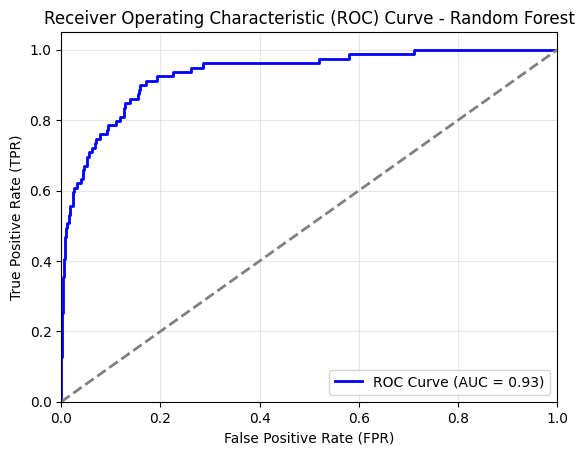

In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

df = pd.read_csv("../../data/data/train-metadata.csv", low_memory=False)

missing_percentages = (df.isnull().sum() / len(df)) * 100
columns_to_keep = missing_percentages[missing_percentages < 50].index
skin_cancer_df = df[columns_to_keep]

features_to_drop = [
    'iddx_full', 'iddx_1', 'iddx_2', 'iddx_3', 'iddx_4', 'iddx_5',
    'isic_id', 'patient_id', 'lesion_id', 'attribution', 'copyright_license'
]

skin_cancer_df = skin_cancer_df.drop(columns=[col for col in features_to_drop if col in skin_cancer_df.columns])
skin_cancer_df = skin_cancer_df.fillna(skin_cancer_df.mode().iloc[0])
categorical_columns = skin_cancer_df.select_dtypes(include=['object']).columns
for col in categorical_columns:
    le = LabelEncoder()
    skin_cancer_df[col] = le.fit_transform(skin_cancer_df[col])

X = skin_cancer_df.drop('target', axis=1)
y = skin_cancer_df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

sm = SMOTE(sampling_strategy=0.1, random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

rf_classifier = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=4,
    random_state=42
)

scores = cross_val_score(rf_classifier, X, y, cv=5, scoring='accuracy')

print("Cross-Validation Scores:", scores)
print("Mean Accuracy:", scores.mean())
print("Standard Deviation:", scores.std())

rf_classifier.fit(X_train_sm, y_train_sm)
y_predict = rf_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_predict)
print(f"\nAccuracy: {accuracy}")
y_prob = rf_classifier.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve - Random Forest')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

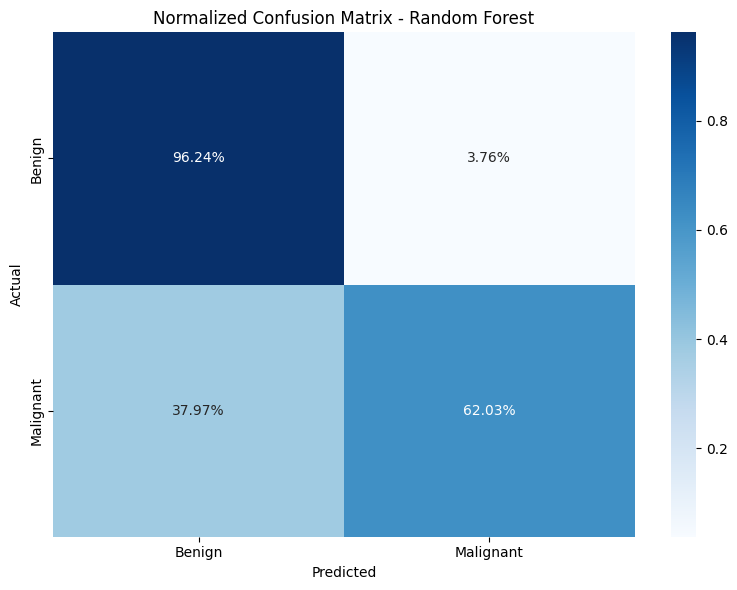

In [ ]:
cm = confusion_matrix(y_test, y_predict)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))

sns.heatmap(cm_normalized,
            annot=True, 
            fmt='.2%',  
            cmap='Blues', 
            xticklabels=['Benign', 'Malignant'],
            yticklabels=['Benign', 'Malignant'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Normalized Confusion Matrix - Random Forest')

plt.tight_layout()

plt.show()